In [62]:
from datetime import datetime
import ccxt

import json
import numpy as np
import pandas as pd
from apscheduler.schedulers.blocking import BlockingScheduler


from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
output_notebook()

from modules.Utils.utils import strategyTester
from warnings import filterwarnings
filterwarnings('ignore')

Loading BokehJS ...

In [2]:
credentials ={
            "apiKey":"62a05a9ccf9fd60001e2ff9e",
            "secret":"578687f6-5420-46d7-9b7a-26a737713cfb",
            "password":"3FiF$4sR6p5Y9fPnSNijL?HaGcd@A7"
}
session = ccxt.kucoin()

In [6]:
order_books = session.fetch_order_book('BTC/USDT')

bids = np.array(order_books['bids'])[:300]
asks = np.array(order_books['asks'])[:300]

OB_df = pd.DataFrame({'bids_price':bids[:,0],
                    'asks_price':asks[:len(bids[:,0]),0],
                        'bids_amount':bids[:,1],
                        'asks_amount':asks[:len(bids[:,0]),1],
                        'bids_volume':bids[:,1]*bids[:,0],
                        'asks_volume':asks[:len(bids[:,0]),1]*asks[:len(bids[:,0]),0],
            },
            dtype=float)
OB_df.head()

,bids_price,asks_price,bids_amount,asks_amount,bids_volume,asks_volume
0,19567.0,19567.1,3.415347,2.423578,66828.102576,47422.395823
1,19566.9,19567.2,0.005494,0.002837,107.496635,55.518799
2,19566.8,19567.3,0.002837,0.002837,55.517664,55.519083
3,19566.7,19567.4,0.002837,0.002220,55.517381,43.430040
4,19566.6,19567.5,0.015614,0.002837,305.503892,55.519650


/home/baptiste/windowsdisk/_sharedFS/Python/python-trading-bot/venv/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


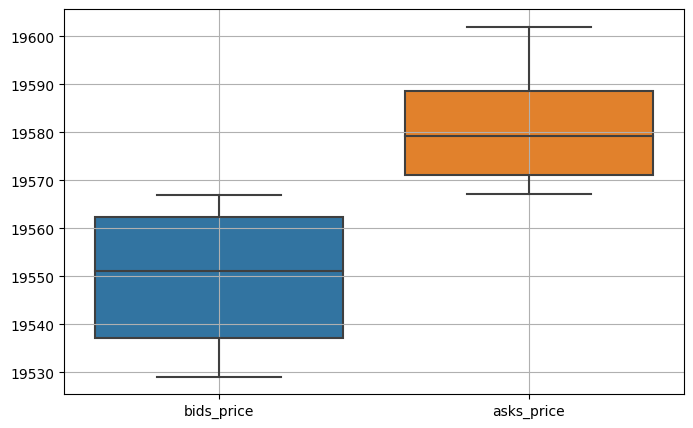

,bids_price,asks_price,bids_amount,asks_amount,bids_volume,asks_volume
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,19550.002000,19580.936000,0.478232,0.404061,9347.558024,7913.304422
std,12.811973,10.675371,0.927269,0.827168,18120.536601,16203.499702
min,19529.100000,19567.100000,0.000016,0.000094,0.304026,1.842541
25%,19537.150000,19571.050000,0.003121,0.005949,61.048294,116.466432
50%,19551.100000,19579.250000,0.100000,0.102109,1954.475000,2000.362248
75%,19562.425000,19588.525000,0.466578,0.507492,9113.279007,9940.588853
max,19567.000000,19602.000000,5.948700,5.948700,116197.146840,116570.130330


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(8, 5))

sns.boxplot(data=OB_df[['bids_price','asks_price']], ax=ax)

plt.grid()
plt.show()
OB_df.describe()

In [ ]:
def cycle():
    order_books = session.fetch_order_book('BTC/USDT',)

    bids = np.array(order_books['bids'])[:300]
    asks = np.array(order_books['asks'])[:300]

    OB_df = pd.DataFrame({'bids_price':bids[:,0],
                        'asks_price':asks[:len(bids[:,0]),0],
                            'bids_amount':bids[:,1],
                            'asks_amount':asks[:len(bids[:,0]),1],
                            'bids_volume':bids[:,1]*bids[:,0],
                            'asks_volume':asks[:len(bids[:,0]),1]*asks[:len(bids[:,0]),0],
                },
                dtype=float)
    OB_df.head()

    print(f'DIFFERENCE (ask - bid) mean : {OB_df.asks_price.mean()- OB_df.bids_price.mean()} $')
    print(f'ASK mean : {OB_df.asks_price.mean()}')
    print(f'QTY DIFFERENCE : {OB_df.bids_amount.mean()-OB_df.asks_amount.mean()}')

    print(f'DIFFERENCE (ask - bid) median : {OB_df.asks_price.median()- OB_df.bids_price.median()} $')
    # spread == difference
    # more spread meaning low liquidity; slow time for price action
    # less spread meaning higher liquidity; faster price action
    print('==================================================================================================')
    total_vol_ask = OB_df['asks_volume'].sum()
    total_vol_bid = OB_df['bids_volume'].sum()
    #
    if total_vol_ask > total_vol_bid:
        print('CURRENT OB BOOKED AT SELLING')
        print('SELLING BOOKED VOLUME: ', total_vol_ask)
        print('BUYING BOOKED VOLUME: ', total_vol_bid)
        print('==================================================================================================')
    elif total_vol_bid > total_vol_ask:
        print('CURRENT OB BOOKED AT BUYING')
        print('BUYING BOOKED VOLUME: ', total_vol_bid)
        print('SELLING BOOKED VOLUME: ', total_vol_ask)
        print('==================================================================================================')
    elif total_vol_bid == total_vol_ask:
        print('CURRENT OB BOOKED AT NEURAL')
        print('BUYING BOOKED VOLUME: ', total_vol_bid)
        print('SELLING BOOKED VOLUME: ', total_vol_ask)
        print('==================================================================================================')


In [63]:
from datetime import datetime

SYMBOL = 'ETH/USDT'

df = pd.read_csv('./depot/orderbook.csv',)
df = df[df['symbol']==SYMBOL]
df.drop(columns=['price_movement','exchange','_id','symbol'], inplace=True)
df['timestamp'] = df.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
df = df.set_index('timestamp')
df.head()

,difference_ask_bid,mean_ask,mean_bid,median_ask,median_bid,qty_difference,std_ask,std_bid,total_vol_ask,total_vol_bid
timestamp,,,,,,,,,,
2022-10-04 07:49:00,2.23,1349.08,1346.85,1348.95,1346.84,0.86818,0.784,0.610,693209.16,808825.97
2022-10-04 07:50:00,2.12,1348.20,1346.08,1348.10,1346.16,0.57472,0.640,0.694,787559.48,863439.62
2022-10-04 07:51:00,2.41,1348.67,1346.26,1348.54,1346.31,-3.21887,0.817,0.747,1157725.28,721978.54
2022-10-04 07:52:00,2.61,1349.95,1347.33,1349.98,1347.44,0.83632,0.708,0.766,576950.02,688405.84
2022-10-04 07:53:00,2.25,1350.44,1348.19,1350.48,1348.24,1.82398,0.577,0.713,673356.57,918004.27


In [64]:
df = df.groupby(pd.Grouper(axis=0, freq='5min')).mean()
df['Direction'] = df.apply(lambda x: 0 if x['total_vol_ask']> x['total_vol_bid'] else 1,axis=1)
df.head()

,difference_ask_bid,mean_ask,mean_bid,median_ask,median_bid,qty_difference,std_ask,std_bid,total_vol_ask,total_vol_bid,Direction
timestamp,,,,,,,,,,,
2022-10-04 07:45:00,2.230,1349.080,1346.850,1348.950,1346.840,0.868180,0.7840,0.6100,693209.160,808825.970,1
2022-10-04 07:50:00,2.292,1349.348,1347.054,1349.306,1347.140,0.640298,0.6692,0.7296,758420.736,843270.328,1
2022-10-04 07:55:00,2.016,1350.384,1348.368,1350.402,1348.466,2.169692,0.5426,0.6566,574744.854,866364.852,1
2022-10-04 08:00:00,2.510,1352.180,1349.674,1352.106,1349.788,1.969186,0.6890,0.8706,550745.882,815446.372,1
2022-10-04 08:05:00,2.638,1357.182,1354.544,1357.132,1354.664,1.543960,0.7678,0.8312,661825.808,869393.732,1


In [65]:
from modules.Utils.utils import loadFromDB
cryptos = loadFromDB('ETH','5m')
cryptos = cryptos.loc[df.index[0]:df.index[-1]]
cryptos['Return'] = cryptos.Close.pct_change()
cryptos.head()

,Open,High,Low,Close,Volume,Timestamp,Return
Date,,,,,,,
2022-10-04 07:45:00,1348.51,1350.00,1346.83,1347.08,3878.7198,1664869500,NaN
2022-10-04 07:50:00,1347.08,1349.42,1346.39,1348.68,2297.0870,1664869800,0.001188
2022-10-04 07:55:00,1348.68,1350.20,1348.67,1350.00,1933.6191,1664870100,0.000979
2022-10-04 08:00:00,1349.99,1354.65,1349.13,1352.74,8089.3203,1664870400,0.002030
2022-10-04 08:05:00,1352.73,1359.67,1352.44,1354.77,10465.7524,1664870700,0.001501


In [66]:
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
output_notebook()

p = figure(title=f"Order book", x_axis_label='time', y_axis_label='values',width=1500, height=600,)

p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(df.index, df.Direction, legend_label="qty_difference", line_width=2, )
#p.line(df.index, df.difference_ask_bid, legend_label="qty_difference", line_width=2, color='orange')
p.legend.location = "top_left"
show(p)

Loading BokehJS ...

In [67]:
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
output_notebook()

p = figure(title=f"Order book", x_axis_label='time', y_axis_label='values',width=1500, height=600,)

p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(cryptos.index, cryptos.Close, legend_label="real data", line_width=2, )
p.legend.location = "top_left"
show(p)

Loading BokehJS ...

In [68]:
df_merged = pd.merge(df, cryptos, left_index=True, right_index=True)
df_merged

,difference_ask_bid,mean_ask,mean_bid,median_ask,median_bid,qty_difference,std_ask,std_bid,total_vol_ask,total_vol_bid,Direction,Open,High,Low,Close,Volume,Timestamp,Return
timestamp,,,,,,,,,,,,,,,,,,
2022-10-04 07:45:00,2.230,1349.080,1346.850,1348.950,1346.840,0.868180,0.7840,0.6100,693209.160,808825.970,1,1348.51,1350.00,1346.83,1347.08,3878.7198,1664869500,NaN
2022-10-04 07:50:00,2.292,1349.348,1347.054,1349.306,1347.140,0.640298,0.6692,0.7296,758420.736,843270.328,1,1347.08,1349.42,1346.39,1348.68,2297.0870,1664869800,0.001188
2022-10-04 07:55:00,2.016,1350.384,1348.368,1350.402,1348.466,2.169692,0.5426,0.6566,574744.854,866364.852,1,1348.68,1350.20,1348.67,1350.00,1933.6191,1664870100,0.000979
2022-10-04 08:00:00,2.510,1352.180,1349.674,1352.106,1349.788,1.969186,0.6890,0.8706,550745.882,815446.372,1,1349.99,1354.65,1349.13,1352.74,8089.3203,1664870400,0.002030
2022-10-04 08:05:00,2.638,1357.182,1354.544,1357.132,1354.664,1.543960,0.7678,0.8312,661825.808,869393.732,1,1352.73,1359.67,1352.44,1354.77,10465.7524,1664870700,0.001501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-16 17:00:00,2.522,1285.872,1283.350,1285.696,1283.434,-1.728494,0.9068,0.7786,1055570.540,831171.752,0,1284.55,1285.45,1284.40,1285.45,534.3180,1665939600,0.000701
2022-10-16 17:05:00,2.458,1286.190,1283.730,1285.996,1283.890,-0.793330,0.8528,0.7748,977383.858,873097.934,0,1285.44,1285.68,1284.83,1285.11,554.2793,1665939900,-0.000264
2022-10-16 17:10:00,2.456,1285.994,1283.534,1285.824,1283.688,-0.285338,0.8182,0.7990,946644.136,907654.176,0,1285.10,1285.11,1283.56,1283.56,757.4206,1665940200,-0.001206


<AxesSubplot: >

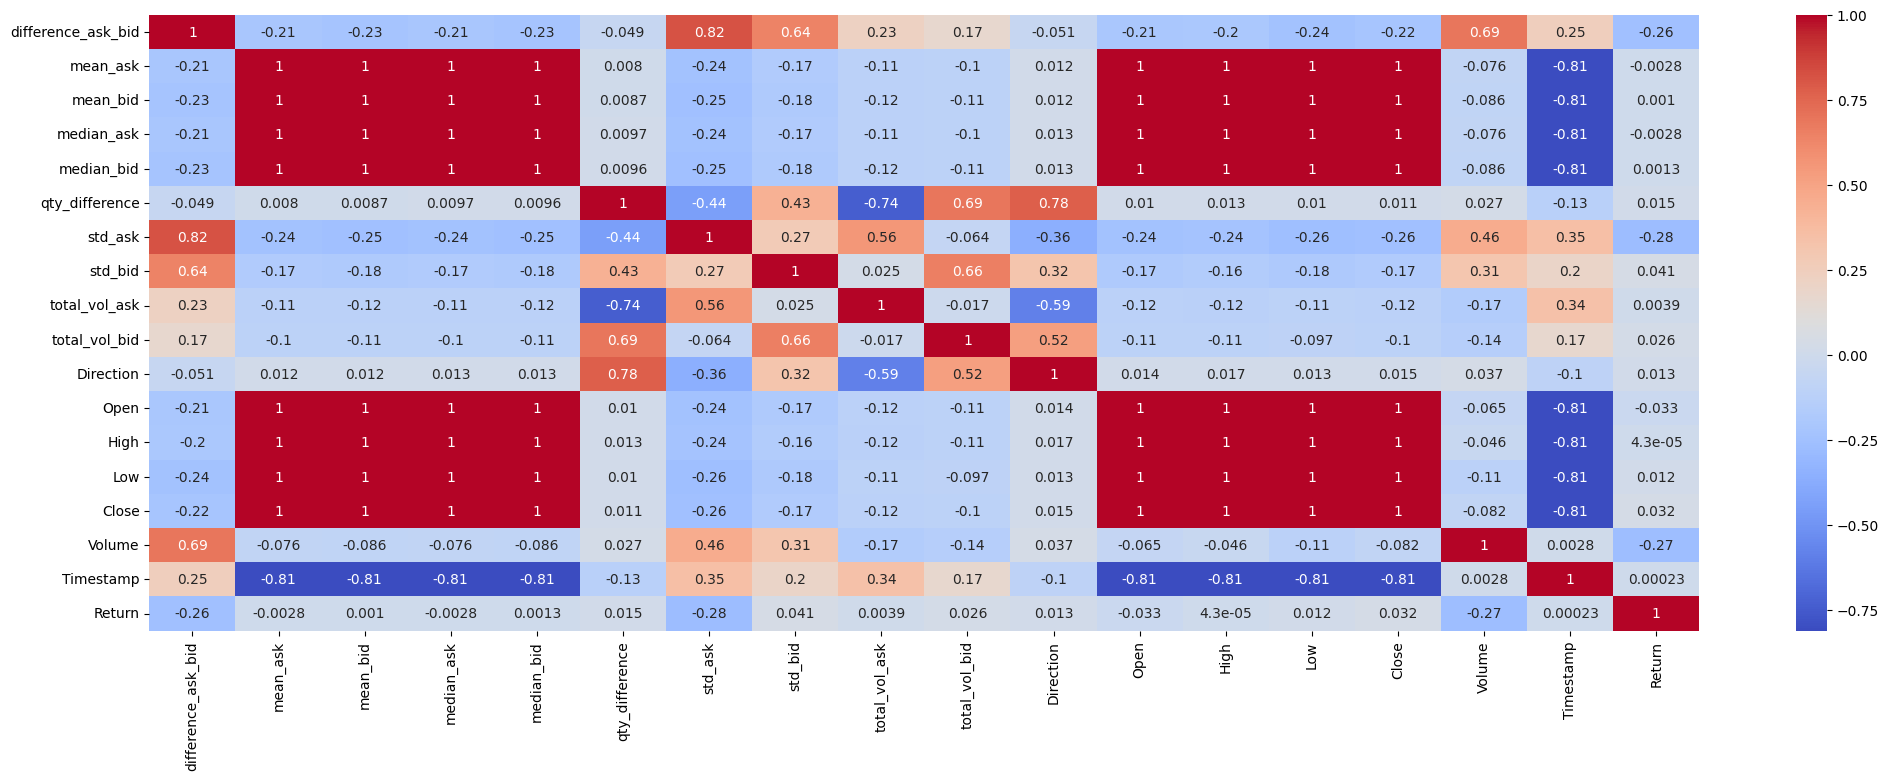

In [69]:
# plot the heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(25,8))
import seaborn as sns

sns.heatmap(df_merged.corr(), annot=True, cmap='coolwarm',
        xticklabels=df_merged.columns,
        yticklabels=df_merged.columns,ax=ax)